<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/7_Fine_CW_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Mon Jun  8 06:52:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from ham10000_utils_functions import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should 

In [0]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 3e-5 # Learning rate

# Data

In [5]:
!git clone https://github.com/filmerxyz/HAM10000_split

Cloning into 'HAM10000_split'...
remote: Enumerating objects: 1024, done.
remote: Counting objects: 100% (1024/1024), done.
remote: Compressing objects: 100% (1022/1022), done.
remote: Total 10062 (delta 3), reused 1021 (delta 2), pack-reused 9038
Receiving objects: 100% (10062/10062), 2.57 GiB | 15.98 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (10021/10021), done.


In [0]:
train_path = '/content/HAM10000_split/train' 
val_path = '/content/HAM10000_split/val'
test_path = '/content/HAM10000_split/test'

## Data Augmentation

In [0]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = train_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = train_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None) 

Found 6303 images belonging to 7 classes.
Found 2707 images belonging to 7 classes.
Found 1005 images belonging to 7 classes.


# Class Weights

In [0]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [0]:
class_weights_dict = { i : class_weights[i] for i in range(0, len(class_weights) ) }

# Model

## Build

In [0]:
def build_model():
  base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
      layer.trainable = True
    else:
      layer.trainable = False

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  
  fc_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=7, activation='softmax', name='prediction')(dropout_layer)

  model = Model(inputs=base_model.input, outputs=prediction_layer)

  return model

In [12]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 2s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Compile

In [0]:
model.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='7_fine_cw_resnet50_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [16]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    class_weight=class_weights_dict,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
197/197 [==============================] - 183s 931ms/step - loss: 2.3008 - accuracy: 0.1510 - val_loss: 1.7982 - val_accuracy: 0.6686 - lr: 3.0000e-05
Epoch 2/100
197/197 [==============================] - 155s 788ms/step - loss: 2.0244 - accuracy: 0.1699 - val_loss: 2.1900 - val_accuracy: 0.6657 - lr: 3.0000e-05
Epoch 3/100
197/197 [==============================] - 156s 792ms/step - loss: 1.8074 - accuracy: 0.1805 - val_loss: 2.2566 - val_accuracy: 0.6535 - lr: 3.0000e-05
Epoch 4/100
197/197 [==============================] - 156s 790ms/step - loss: 1.7214 - accuracy: 0.1929 - val_loss: 2.2726 - val_accuracy: 0.4448 - lr: 3.0000e-05
Epoch 5/100
197/197 [==============================] - 155s 787ms/step - loss: 1.6792 - accuracy: 0.1944 - val_loss: 2.8711 - val_accuracy: 0.1685 - lr: 3.0000e-05
Epoch 6/100
197/197 [==============================] - 153s 777ms/step - loss: 1.6341 - accuracy: 0.2066 - val_loss: 2.0813 - val_accuracy: 0.2327 - lr: 3.0000e-05
Epoch 7/100
197/

# Graph

## Accuracy

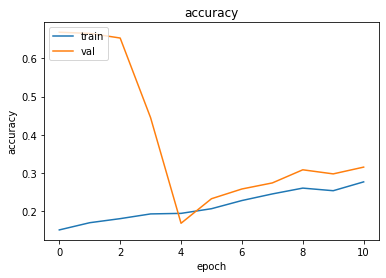

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

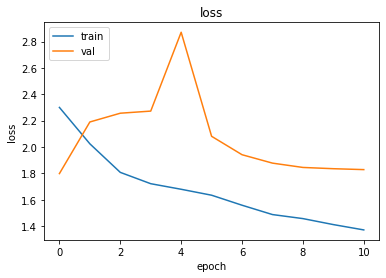

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [0]:
test_model = tf.keras.models.load_model('/content/7_fine_cw_resnet50_model.h5')

In [0]:
num_test_files = len(test_generator.filenames)

In [0]:
test_generator.reset()

In [0]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

## Confusion Matrix

### Without Normalize

Confusion matrix, without normalization
[[  0   0   0   0   0  33   0]
 [  0   0   0   1   0  51   0]
 [  0   0   0   0   0 110   0]
 [  0   0   0   0   0  12   0]
 [  0   0   0   0   0 112   0]
 [  0   0   0   1   0 670   0]
 [  0   0   0   0   0  15   0]]


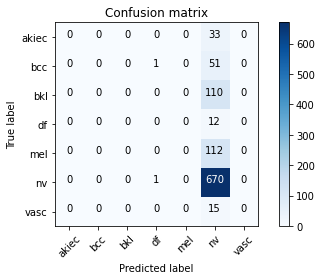

In [23]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.01923077 0.         0.98076923
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.00149031 0.         0.99850969
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]]


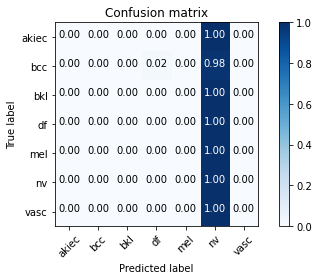

In [24]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [25]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[  0   0   0   0   0  33   0]
 [  0   0   0   1   0  51   0]
 [  0   0   0   0   0 110   0]
 [  0   0   0   0   0  12   0]
 [  0   0   0   0   0 112   0]
 [  0   0   0   1   0 670   0]
 [  0   0   0   0   0  15   0]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        52
         bkl       0.00      0.00      0.00       110
          df       0.00      0.00      0.00        12
         mel       0.00      0.00      0.00       112
          nv       0.67      1.00      0.80       671
        vasc       0.00      0.00      0.00        15

    accuracy                           0.67      1005
   macro avg       0.10      0.14      0.11      1005
weighted avg       0.45      0.67      0.53      1005



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Sensitivity & Specificity

In [26]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: nan
specificity: nan


# Grad-CAM

In [0]:
last_conv2d = 'conv5_block3_3_conv'

## AKIEC

In [0]:
akiec_img = '/content/HAM10000_split/train/akiec/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.842
	bkl            	(2)	with probability 0.058
	bcc            	(1)	with probability 0.047
	akiec          	(0)	with probability 0.036
	nv             	(5)	with probability 0.008
Explanation for 'mel'


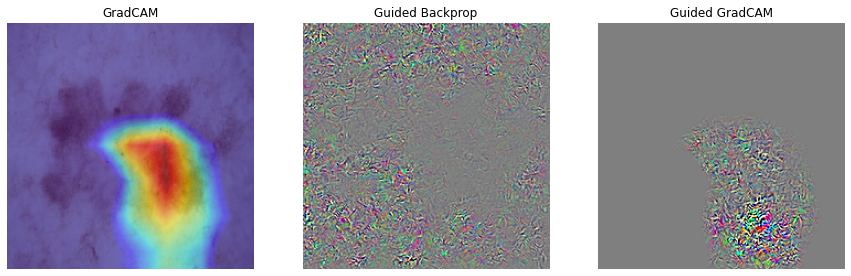

In [30]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

## BCC

In [0]:
bcc_img = '/content/HAM10000_split/train/bcc/ISIC_0024332.jpg'

Model prediction:
	df             	(3)	with probability 0.328
	mel            	(4)	with probability 0.214
	bcc            	(1)	with probability 0.174
	bkl            	(2)	with probability 0.110
	nv             	(5)	with probability 0.092
Explanation for 'df'


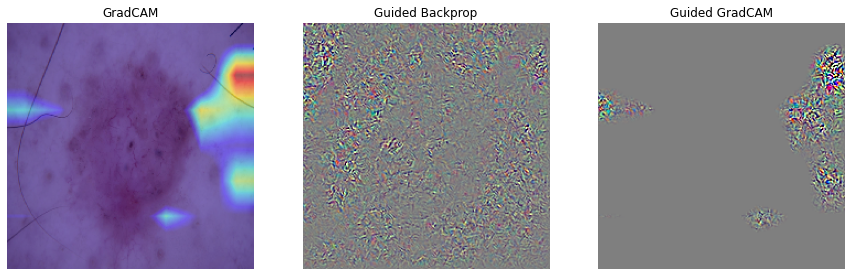

In [32]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

## BKL

In [0]:
bkl_img = '/content/HAM10000_split/train/bkl/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.435
	bkl            	(2)	with probability 0.245
	bcc            	(1)	with probability 0.140
	vasc           	(6)	with probability 0.123
	akiec          	(0)	with probability 0.022
Explanation for 'mel'


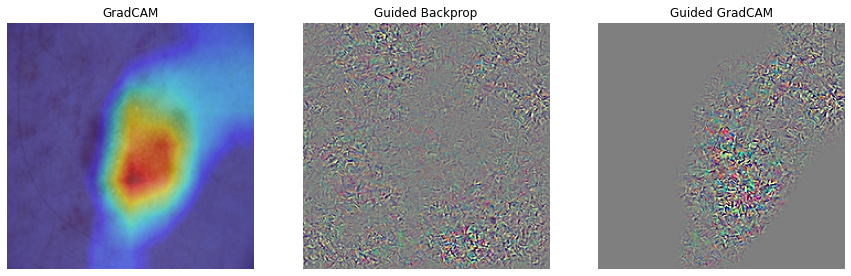

In [36]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

## DF

In [0]:
df_img = '/content/HAM10000_split/val/df/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.955
	nv             	(5)	with probability 0.016
	bkl            	(2)	with probability 0.015
	df             	(3)	with probability 0.008
	vasc           	(6)	with probability 0.003
Explanation for 'mel'


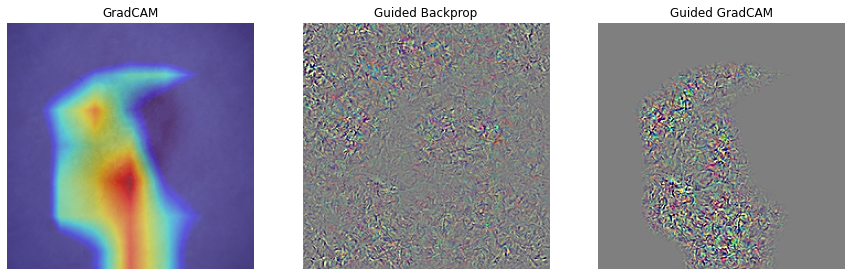

In [38]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

## MEL

In [0]:
mel_img = '/content/HAM10000_split/train/mel/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.465
	bkl            	(2)	with probability 0.294
	bcc            	(1)	with probability 0.109
	vasc           	(6)	with probability 0.056
	akiec          	(0)	with probability 0.034
Explanation for 'mel'


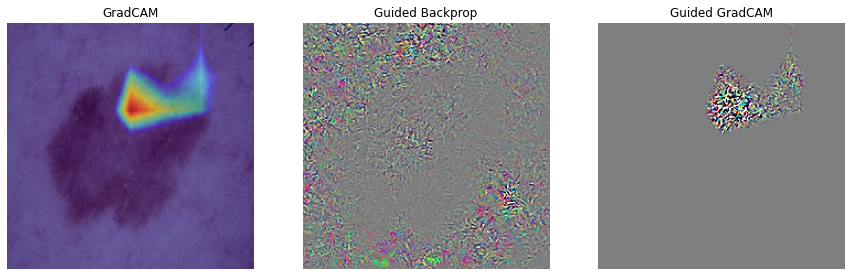

In [40]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

## NV

In [0]:
nv_img = '/content/HAM10000_split/val/nv/ISIC_0024349.jpg'

Model prediction:
	bkl            	(2)	with probability 0.980
	vasc           	(6)	with probability 0.014
	df             	(3)	with probability 0.003
	nv             	(5)	with probability 0.002
	bcc            	(1)	with probability 0.000
Explanation for 'bkl'


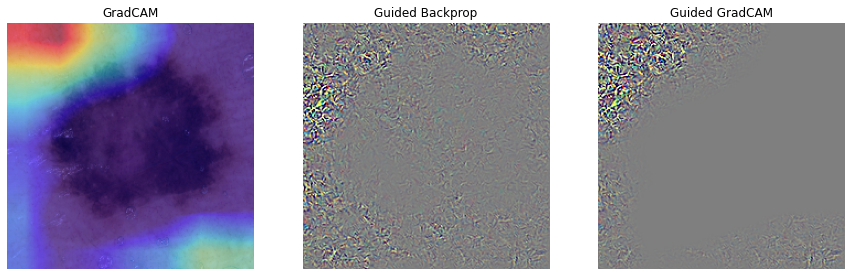

In [42]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

## VASC

In [0]:
vasc_img = '/content/HAM10000_split/test/vasc/ISIC_0025452.jpg'

Model prediction:
	vasc           	(6)	with probability 0.818
	nv             	(5)	with probability 0.146
	df             	(3)	with probability 0.028
	mel            	(4)	with probability 0.004
	bkl            	(2)	with probability 0.003
Explanation for 'vasc'


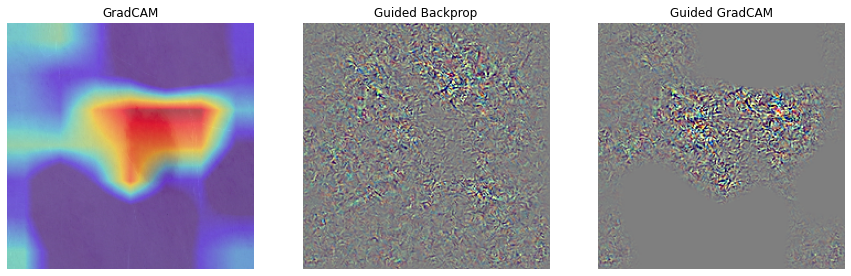

In [44]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)